# KMeans clustering 

This notebook is dedicated to the clustering task using KMeans algorith. The notebook is divided into the following sections:
1. in the first part we use the KMeans algorithm for the `features of the cyclists`, including the original ones and the ones we created during the task 2.
2. in the second part we use the KMeans algorithm again for the `features of the races` (original and engineered ones).

For each part, we will:
- load the data
- preprocess the data
- do the grid search to find the best number of clusters `k`
- apply the KMeans algorithm
- evaluate the results

# Features of the cyclists

In [1]:
import copy
from os import path

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.model_selection import ParameterSampler
import pandas as pd
import numpy as np
import seaborn

from transformations import center_and_scale

# show all elements of a dataframe
# pandas.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)



## Hyperparameter search for K-Means

In [2]:
# since several algorithms are randomized, we set a seed to repeat them
RANDOM_STATE = 42

# load dataset
datasetname = path.join('..','dataset', 'cyclists_final_enhanced.csv')
cyclists=pd.read_csv(datasetname)
numeric_dataset = cyclists.select_dtypes(include="number")
normalized_df, normalization_scalers_df = center_and_scale(numeric_dataset)

In [3]:
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterSampler
import pandas as pd
import copy

# Precompute constants
max_distance = abs(normalized_df.max() - normalized_df.min()).sum().item()
avg_concentration = normalized_df.shape[0] / max_distance

# Algorithm configuration
kmeans_params = {
    "n_clusters": list(range(2, 8)) + [16, 32],
    "max_iter": [10],
    "random_state": [RANDOM_STATE],
    "n_init": [10]
}

# Sample hyperparameters and fit models
sampled_params = list(ParameterSampler(copy.deepcopy(kmeans_params), n_iter=5, random_state=RANDOM_STATE))
kmeans_models = [KMeans(**params).fit(normalized_df.values) for params in sampled_params]

# Extract clustering results and metadata
results = [
    {
        **params,
        "algorithm": "kmeans",
        "n_clusters": getattr(model, "n_clusters", params.get("n_clusters", 0))
    }
    for model, params in zip(kmeans_models, sampled_params)
]

# Create and clean results DataFrame
results_df = pd.DataFrame(results)
results_df["random_state"] = RANDOM_STATE
results_df.fillna({"max_iter": -1, "n_init": -1}, inplace=True)
results_df = results_df.astype({"n_clusters": int, "random_state": int})

results_df


,random_state,n_init,n_clusters,max_iter,algorithm
0,42,10,3,10,kmeans
1,42,10,7,10,kmeans
2,42,10,2,10,kmeans
3,42,10,32,10,kmeans
4,42,10,4,10,kmeans


## Evaluation

In [4]:
clusterings = [model.labels_ for model in kmeans_models]

silhouette_per_model = [
    silhouette_score(normalized_df, clustering) if len(set(clustering)) > 1 else -1
    for clustering in clusterings
]

results_df.loc[:, "silhouette"] = silhouette_per_model
results_df = results_df.sort_values(by="silhouette", ascending=False)

results_df


,random_state,n_init,n_clusters,max_iter,algorithm,silhouette
2,42,10,2,10,kmeans,0.285792
4,42,10,4,10,kmeans,0.222714
0,42,10,3,10,kmeans,0.222235
1,42,10,7,10,kmeans,0.187506
3,42,10,32,10,kmeans,0.150502


## Cohesion

In [5]:
from scipy.spatial.distance import cdist


clusterings_cohesions = list()
for i, clustering in enumerate(clusterings):
    clusters_indices = [np.argwhere(clustering == target_cluster).squeeze()
                        for target_cluster in np.unique(clustering)]
    centroids = [normalized_df.values[cluster].mean(axis=0)
                 for cluster in clusters_indices]
    mean_distances = [sum(cdist([centroid], normalized_df.values[indices]).squeeze()).item()
                      for centroid, indices in zip(centroids, clusters_indices) if centroid.ndim > 0]
    clusterings_cohesions.append(mean_distances)

summed_cohesions = [sum(cohesion) for cohesion in clusterings_cohesions]
results_df.loc[:, "cohesion"] = summed_cohesions
results_df.sort_values(by="silhouette")

,random_state,n_init,n_clusters,max_iter,algorithm,silhouette,cohesion
3,42,10,32,10,kmeans,0.150502,12854.596629
1,42,10,7,10,kmeans,0.187506,7955.479395
0,42,10,3,10,kmeans,0.222235,14680.562115
4,42,10,4,10,kmeans,0.222714,11056.371468
2,42,10,2,10,kmeans,0.285792,13308.124411


<Axes: xlabel='n_clusters', ylabel='silhouette'>

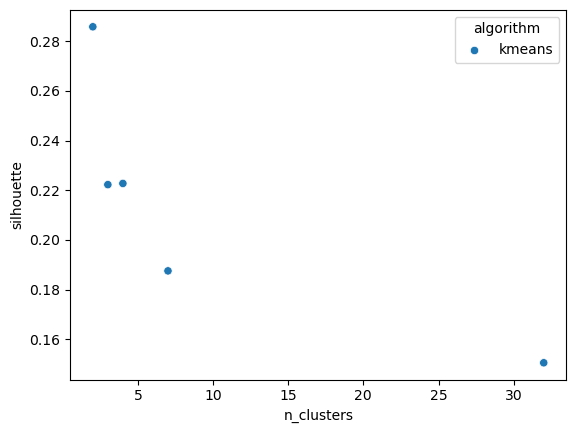

In [6]:
import seaborn


seaborn.scatterplot(
    results_df,
    x="n_clusters",
    y="silhouette",
    hue="algorithm"
)

We choose for the cyclists k=2 because the cohesion is the highest for k=2 and the silhouette score is the highest for k=2.

## How do clusters relate with original data?

In [7]:
reference_clustering_index = 4
reference_clustering = clusterings[reference_clustering_index]
clustering_dataframe = pd.DataFrame(reference_clustering, columns=["clustering"])
dataset_with_clustering = pd.concat((cyclists, clustering_dataframe), axis="columns")

# for simplicity, only show a subset of the data
dataset_with_clustering = dataset_with_clustering.iloc[:reference_clustering.size, :]

dataset_with_clustering = dataset_with_clustering.astype({"clustering": int})
dataset_with_clustering.head()

,_url,name,birth_year,weight,height,nationality,bmi,career_points,career_duration(days),career_duration(races),debut_year,avg_pos,clustering
0,bruno-surra,Bruno Surra,1964,73.0,185,Italy,21.329438,80.0,1.0,1.0,1989.0,110.000000,0
1,gerard-rue,Gérard Rué,1965,74.0,182,France,22.340297,26105.0,3492.0,222.0,1988.0,63.545045,3
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,19.316369,4425.0,519.0,49.0,2022.0,87.693878,0
3,nathan-van-hooydonck,Nathan Van Nathan Van Hooydonck,1995,78.0,192,Belgium,21.158854,17205.0,1982.0,161.0,2018.0,83.242236,0
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,18.809206,3085.0,721.0,48.0,2021.0,68.000000,0


In [8]:
clusters_sizes = np.unique(reference_clustering, return_counts=True)[1]
average_cyclist_per_cluster = dataset_with_clustering.groupby("clustering")\
    .describe()\
    .xs(                  # select from a multi-index dataframe
        "mean",           # which columns to select?
        level=1,          # at what level of the index?
        drop_level=True,  
        axis="columns"
    )
average_cyclist_per_cluster.loc[:, "cluster_size"] = clusters_sizes
std_cyclist_per_cluster = dataset_with_clustering.groupby("clustering")\
    .describe()\
    .xs(                  # select from a multi-index dataframe
        "std",           # which columns to select?
        level=1,          # at what level of the index?
        drop_level=True,  
        axis="columns"
    )
std_cyclist_per_cluster.loc[:, "cluster_size"] = clusters_sizes


average_cyclist_per_cluster


,birth_year,weight,height,bmi,career_points,career_duration(days),career_duration(races),debut_year,avg_pos,cluster_size
clustering,,,,,,,,,,
0,1983.301799,68.444437,180.208861,21.055637,3731.795602,956.431046,44.897069,2007.882079,97.864823,3002
1,1957.406019,68.860665,179.201162,21.433876,3104.091430,1149.440866,28.348469,1982.323654,44.874447,1894
2,1979.974359,67.564103,179.333333,20.986503,0.000000,0.000000,0.000000,0.000000,-1.000000,39
3,1977.014178,68.617598,179.727273,21.222999,29646.972607,4109.427023,334.772310,2000.203503,72.251112,1199


In [9]:
std_cyclist_per_cluster

,birth_year,weight,height,bmi,career_points,career_duration(days),career_duration(races),debut_year,avg_pos,cluster_size
clustering,,,,,,,,,,
0,11.475233,6.217838,6.311213,1.322656,4152.114220,989.817477,50.424189,10.844148,24.428771,3002
1,9.068699,5.906739,6.125486,1.393106,4246.357216,1195.713827,40.651808,8.760130,24.405150,1894
2,11.741710,6.340326,5.521886,1.445792,0.000000,0.000000,0.000000,0.000000,0.000000,39
3,10.387997,6.037060,6.069012,1.286628,12494.562218,1074.229861,145.030464,10.254945,20.206904,1199


## What features are relevant to clustering

In [10]:
average_cyclist_per_cluster.std().sort_values()

bmi                           0.199248
height                        0.453081
weight                        0.564818
birth_year                   11.632462
avg_pos                      42.286688
career_duration(races)      156.282054
debut_year                  998.458956
cluster_size               1242.560931
career_duration(days)      1776.314527
career_points             13781.084922
dtype: float64

## Clustering Preprocessing

In [11]:
cyclists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   _url                    6134 non-null   object 
 1   name                    6134 non-null   object 
 2   birth_year              6134 non-null   int64  
 3   weight                  6134 non-null   float64
 4   height                  6134 non-null   int64  
 5   nationality             6134 non-null   object 
 6   bmi                     6134 non-null   float64
 7   career_points           6134 non-null   float64
 8   career_duration(days)   6134 non-null   float64
 9   career_duration(races)  6134 non-null   float64
 10  debut_year              6134 non-null   float64
 11  avg_pos                 6134 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 575.2+ KB


In [12]:
# since several algorithms are randomized, we set a seed to repeat them
RANDOM_STATE = 42

# load dataset
datasetname = path.join('..','dataset', 'cyclists_final_enhanced.csv')
cyclists = pd.read_csv(datasetname)
num_columns = ['bmi', 'height', 'weight', 'birth_year', 'avg_pos', 'career_duration(races)', 'debut_year', 'career_duration(days)', 'career_points']
cat_columns = ['nationality']
df = cyclists.copy()
numeric_dataset = df[num_columns]
cat_dataset = df[cat_columns]

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(numeric_dataset)
X = scaler.transform(numeric_dataset)

In [14]:
pd.DataFrame(scaler.inverse_transform(scaler.transform(numeric_dataset)), columns=numeric_dataset.columns)

,bmi,height,weight,birth_year,avg_pos,career_duration(races),debut_year,career_duration(days),career_points
0,21.329438,185.0,73.0,1964.0,110.000000,1.0,1989.0,1.0,80.0
1,22.340297,182.0,74.0,1965.0,63.545045,222.0,1988.0,3492.0,26105.0
2,19.316369,189.0,69.0,1996.0,87.693878,49.0,2022.0,519.0,4425.0
3,21.158854,192.0,78.0,1995.0,83.242236,161.0,2018.0,1982.0,17205.0
4,18.809206,171.0,55.0,1997.0,68.000000,48.0,2021.0,721.0,3085.0
...,...,...,...,...,...,...,...,...,...
6129,19.350208,179.0,62.0,1966.0,10.000000,1.0,1993.0,1.0,80.0
6130,21.220009,188.0,75.0,1998.0,84.576923,26.0,2020.0,1140.0,2410.0
6131,20.451146,181.0,67.0,1973.0,106.500000,12.0,1997.0,311.0,955.0
6132,20.069204,170.0,58.0,1985.0,71.929204,113.0,2009.0,1849.0,8920.0


In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [16]:
kmeans = KMeans(
    n_clusters=2,         
    random_state=42,      
    max_iter=10           
)
kmeans.fit(X)

KMeans(max_iter=10, n_clusters=2, random_state=42)

In [17]:
kmeans.labels_[:5]

array([0, 1, 0, 0, 1], dtype=int32)

In [18]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1], dtype=int32), array([4388, 1746]))

In [19]:
kmeans.cluster_centers_

array([[ 0.15639808,  0.19248836,  0.25624478, -0.06758206,  0.0505529 ,
        -0.479278  , -0.03173963, -0.48066126, -0.47924527],
       [-0.30975635, -0.38123544, -0.50750909,  0.13385057, -0.10012324,
         0.94924058,  0.06286235,  0.95198021,  0.94917577]])

In [20]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

## Clusterings of the features linked to the physical characteristics of the cyclists

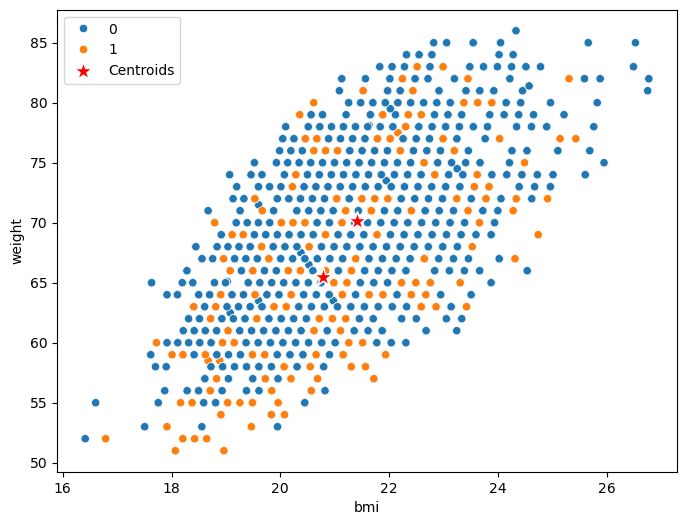

In [21]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="bmi", y="weight", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,0], y=centers[:, 2], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('bmi')
plt.ylabel('weight')

# Display the plot
plt.legend()
plt.show()

here the division between the two clusters is not clear, they seem to be overlapping, we do the same with height to see if we can find a better division.

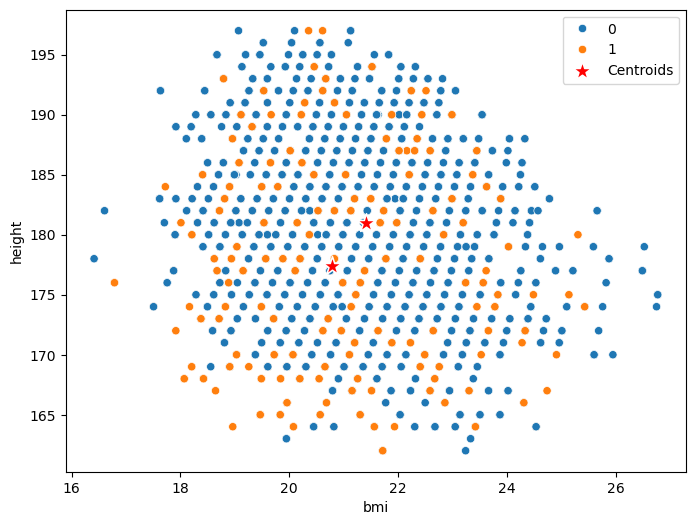

In [22]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="bmi", y="height", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,0], y=centers[:, 1], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('bmi')
plt.ylabel('height')

# Display the plot
plt.legend()
plt.show()

As for weight, the division is not clear, meaning that the weight is not a good feature to cluster the cyclists.


## Clustering of the features linked to the performance of the cyclists

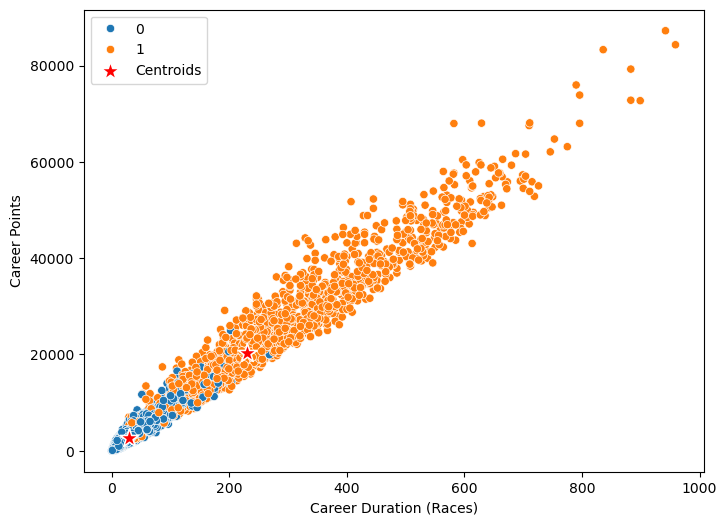

In [23]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="career_duration(races)", y="career_points", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,5], y=centers[:, 8], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('Career Duration (Races)')
plt.ylabel('Career Points')

# Display the plot
plt.legend()
plt.show()

Like we've seen during the data understanding there is a strong positive correlation between the Career points and the career duration. This is also reflected in the clustering of the cyclists. We can distinguish the following groups:
- `Cluster 0`: Cyclists with a short career duration and a low number of career points.
- `Cluster 1`: Cylists with a slightly longer career duration and a slightly higher number of career points. 

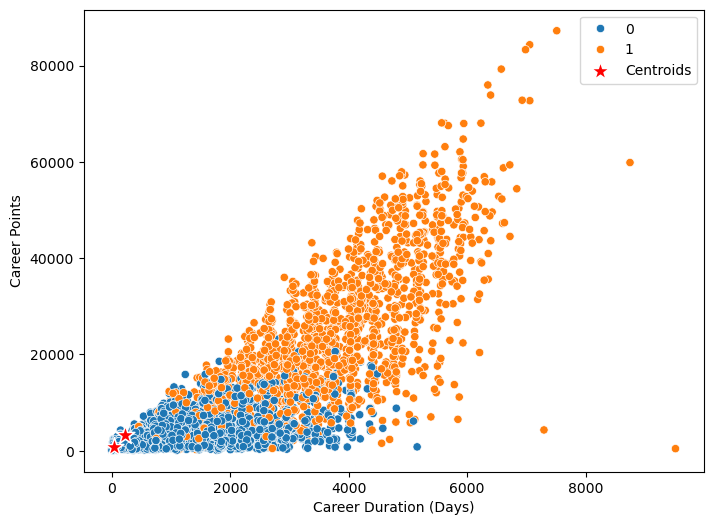

In [24]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="career_duration(days)", y="career_points", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,5], y=centers[:, 7], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('Career Duration (Days)')
plt.ylabel('Career Points')

# Display the plot
plt.legend()
plt.show()

As for the clustering with the career points and the career duration in races, we can see that the clustering is able to separate the cyclists in different groups and again most of the cyclists that have accumulated a high number of career points have also a long career duration.

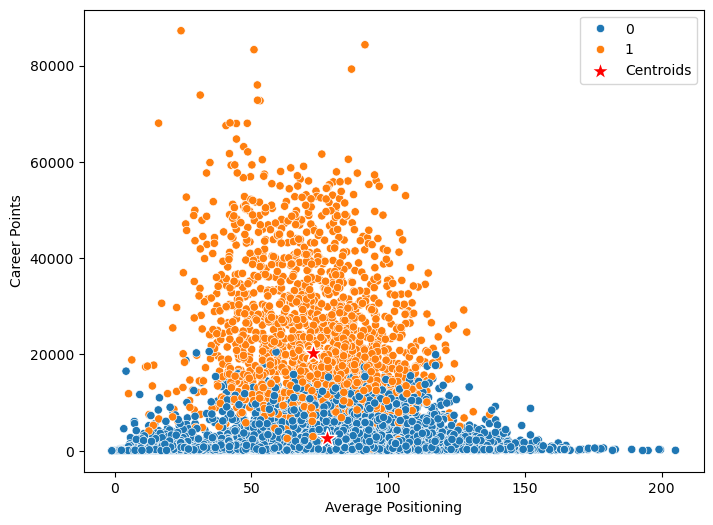

In [25]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="avg_pos", y="career_points", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,4], y=centers[:, 8], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('Average Positioning')
plt.ylabel('Career Points')

# Display the plot
plt.legend()
plt.show()

As we can see from the graph above, each cluster represent a different group of cyclists. We can distinguish the following groups:
- `Cluster 1`: This cluster represents the cyclists with a moderate to high number of career points. We can see that the average positioning of the cyclists in this cluster is less sparse than the other cluster and tend to be more concentrated between the 50 and 100 position with few exception of cyclists that have a higher number of career points and a lower average positioning meaning that they have a better performance.
- `Cluster 0`: This cluster represents the cyclists with a low number of career points. We can see that the average positioning of the cyclists in this cluster is more sparse than the other cluster.

Visualization of the clusters by means of parallel coordinates

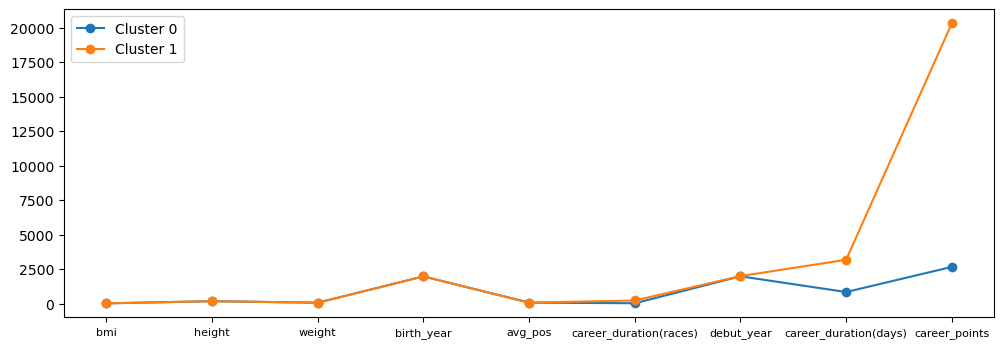

In [26]:
plt.figure(figsize=(12, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(numeric_dataset.columns)), numeric_dataset.columns, fontsize=8)
plt.legend(fontsize=10)
plt.show()

The two clusters are not clearly separated for what concerns the biological characteristics, however they are clearly separated for what concerns the career_duration expressed in days and the career points accumulated by the cyclists. The cluster 0 is composed by cyclists with a low number of career points and a short career duration, while the cluster 1 is composed by cyclists with a higher number of career points and a longer career duration.

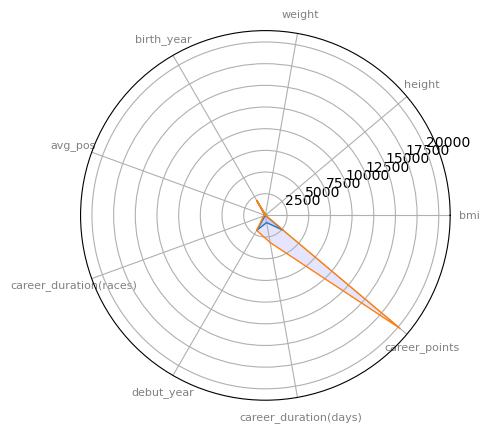

In [27]:
from math import pi
 
# number of variable
N = len(numeric_dataset.columns)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]
# Initialise the spider plot
    ax = plt.subplot(polar=True)
# Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], numeric_dataset.columns, color='grey', size=8) 
# Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
 # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

# Features of the races

In [28]:
import copy
from os import path

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.model_selection import ParameterSampler
import pandas as pd
import numpy as np
import seaborn

from transformations import center_and_scale

# show all elements of a dataframe
# pandas.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## Clustering preprocessing

In [29]:
# since several algorithms are randomized, we set a seed to repeat them
RANDOM_STATE = 42

# load dataset
datasetname = path.join('..','dataset', 'engineered_races.csv')
races=pd.read_csv(datasetname)
numeric_dataset = races.select_dtypes(include="number")
normalized_df, normalization_scalers_df = center_and_scale(numeric_dataset)

In [30]:
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterSampler
import pandas as pd
import copy

# Compute hyperparameter sampling and fit KMeans models
kmeans_params = {
    "n_clusters": list(range(2, 8)) + [16, 32],
    "max_iter": [10],
    "random_state": [RANDOM_STATE],
    "n_init": [10]
}

# Sample hyperparameters and fit models
sampled_params = list(ParameterSampler(copy.deepcopy(kmeans_params), n_iter=5, random_state=RANDOM_STATE))
kmeans_models = [KMeans(**params).fit(normalized_df.values) for params in sampled_params]

# Extract clustering labels
clusterings = [model.labels_ for model in kmeans_models]

# Collect results with hyperparameter configurations
results = [
    {
        **params,
        "algorithm": "kmeans",
        "n_clusters": getattr(model, "n_clusters", params.get("n_clusters", 0))
    }
    for model, params in zip(kmeans_models, sampled_params)
]

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df["random_state"] = RANDOM_STATE

# Clean and format DataFrame
results_df.fillna({"max_iter": -1, "n_init": -1}, inplace=True)
results_df = results_df.astype({"n_clusters": int, "random_state": int})

results_df


,random_state,n_init,n_clusters,max_iter,algorithm
0,42,10,3,10,kmeans
1,42,10,7,10,kmeans
2,42,10,2,10,kmeans
3,42,10,32,10,kmeans
4,42,10,4,10,kmeans


## Evaluation

In [31]:
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed
import pandas as pd


silhouette_per_model = [
    silhouette_score(normalized_df, clustering, sample_size=20000)
    for clustering in clusterings
]

results_df["silhouette"] = silhouette_per_model
results_df = results_df.sort_values(by="silhouette", ascending=False)

results_df


,random_state,n_init,n_clusters,max_iter,algorithm,silhouette
0,42,10,3,10,kmeans,0.179354
1,42,10,7,10,kmeans,0.163575
2,42,10,2,10,kmeans,0.159544
4,42,10,4,10,kmeans,0.157381
3,42,10,32,10,kmeans,0.138651


## Cohesion

In [32]:
from scipy.spatial.distance import cdist


clusterings_cohesions = list()
for i, clustering in enumerate(clusterings):
    clusters_indices = [np.argwhere(clustering == target_cluster).squeeze()
                        for target_cluster in np.unique(clustering)]
    centroids = [normalized_df.values[cluster].mean(axis=0)
                 for cluster in clusters_indices]
    mean_distances = [sum(cdist([centroid], normalized_df.values[indices]).squeeze()).item()
                      for centroid, indices in zip(centroids, clusters_indices) if centroid.ndim > 0]
    clusterings_cohesions.append(mean_distances)

summed_cohesions = [sum(cohesion) for cohesion in clusterings_cohesions]
results_df.loc[:, "cohesion"] = summed_cohesions
results_df.sort_values(by="silhouette")

,random_state,n_init,n_clusters,max_iter,algorithm,silhouette,cohesion
3,42,10,32,10,kmeans,0.138651,1.646764e+06
4,42,10,4,10,kmeans,0.157381,1.102448e+06
2,42,10,2,10,kmeans,0.159544,1.839078e+06
1,42,10,7,10,kmeans,0.163575,1.513562e+06
0,42,10,3,10,kmeans,0.179354,1.749875e+06


<Axes: xlabel='n_clusters', ylabel='silhouette'>

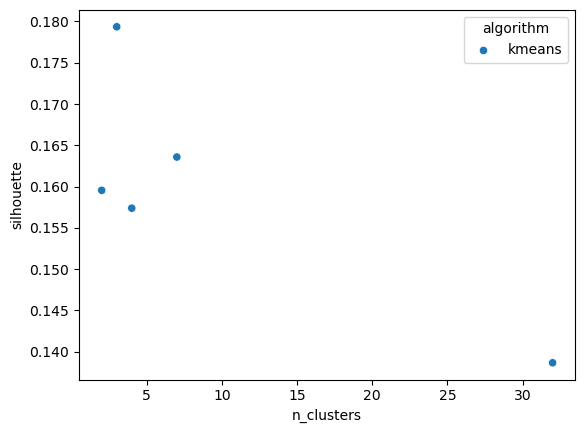

In [45]:
import seaborn


seaborn.scatterplot(
    results_df,
    x="n_clusters",
    y="silhouette",
    hue="algorithm"
)

Here we use k=3 because the cohesion is the highest for k=3 and the silhouette score is the highest for k=3.

## Clustering preprocessing

In [33]:
# since several algorithms are randomized, we set a seed to repeat them
RANDOM_STATE = 42

# load dataset
datasetname = path.join('..','dataset', 'engineered_races.csv')
races = pd.read_csv(datasetname)
num_columns = ['points', 'length', 'climb_total', 'profile', 'startlist_quality', 'position', 'cyclist_age', 'delta', 'climbing_efficiency', 'competitive_age', 'difficulty', 'convenience_score', 'difficulty_score', 'performance_index', 'gain_ratio']
cat_columns = ['cyclist_team', 'difficulty_level', 'std_name', 'stage']
df = races.copy()
numeric_dataset = df[num_columns]
cat_dataset = df[cat_columns]

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(numeric_dataset)
X = scaler.transform(numeric_dataset)

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [36]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=10)
kmeans.fit(X)

KMeans(max_iter=10, n_clusters=3, n_init=10)

In [37]:
kmeans.cluster_centers_

array([[-1.40156412e-01, -3.11476914e-01, -8.02277784e-01,
        -9.26560140e-01,  3.80729458e-01,  2.26459167e-01,
         1.18526791e-03, -2.82134197e-01, -1.47635489e-01,
         1.19978039e-03, -1.86522893e-01,  5.99146131e-01,
        -9.26665447e-01, -2.08164781e-01,  1.81086197e-01],
       [-3.56627854e-01,  4.13998033e-02,  5.49212448e-01,
         6.76327888e-01, -2.27307088e-01, -9.87709929e-02,
         7.00874772e-03,  2.18135238e-01,  1.35217914e-01,
         6.96040087e-03, -5.63847087e-02, -3.55856571e-01,
         6.00306979e-01,  1.24521575e-01, -1.30268203e-01],
       [ 3.04187731e+00,  1.22245501e+00,  2.09866756e-01,
        -3.67520858e-02, -3.20898169e-01, -4.32789745e-01,
        -5.22378904e-02, -9.21746033e-02, -1.88156080e-01,
        -5.19866201e-02,  1.27107975e+00, -5.17288143e-01,
         4.68553330e-01,  1.73852516e-01, -5.51867860e-03]])

In [38]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

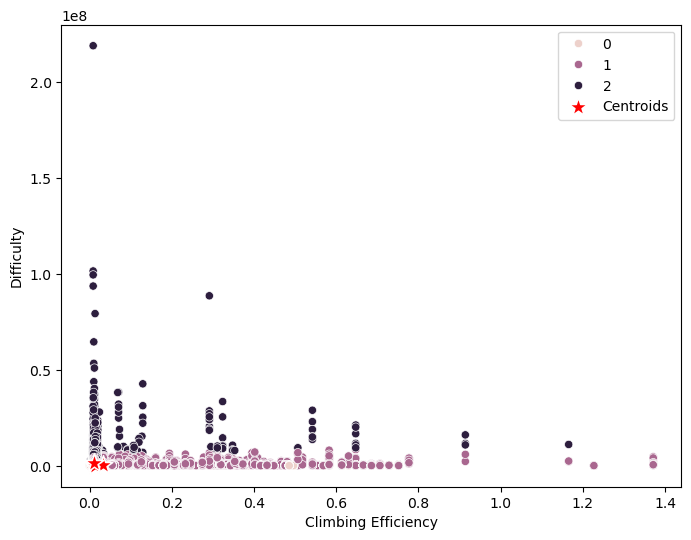

In [39]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="climbing_efficiency", y="difficulty", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,8], y=centers[:, 10], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('Climbing Efficiency')
plt.ylabel('Difficulty')

# Display the plot
plt.legend()
plt.show()

The majority of points are concentrated on the bottom left of the graph, this is reflected by the positioning of the centroids there.
- `Cluster 1` seems to have higher difficulty overall and low climbing efficiency
- `Clsuter 0 and 2` seems to overlap, suggesting that this two features are not enough to separate them.

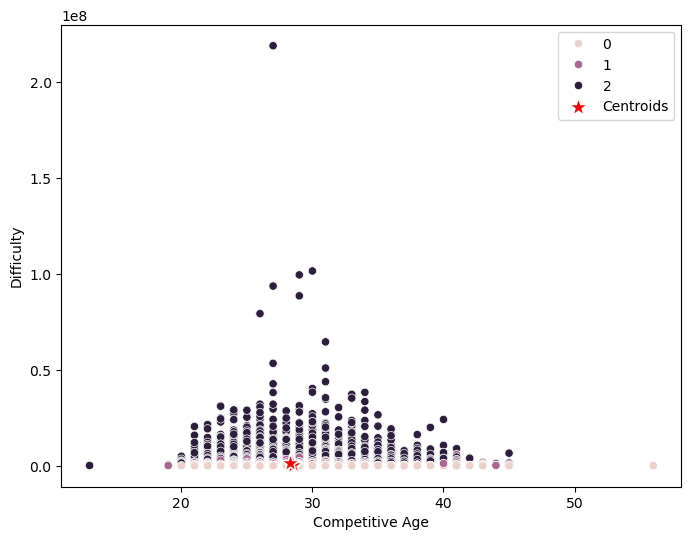

In [40]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="competitive_age", y="difficulty", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,9], y=centers[:, 10], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('Competitive Age')
plt.ylabel('Difficulty')

# Display the plot
plt.legend()
plt.show()

Again, `cluster 1` includes some outliers with extremely high difficulty values while `cluster 0` and `cluster 2` cover the lower region of the graph making them difficult to distinguish.

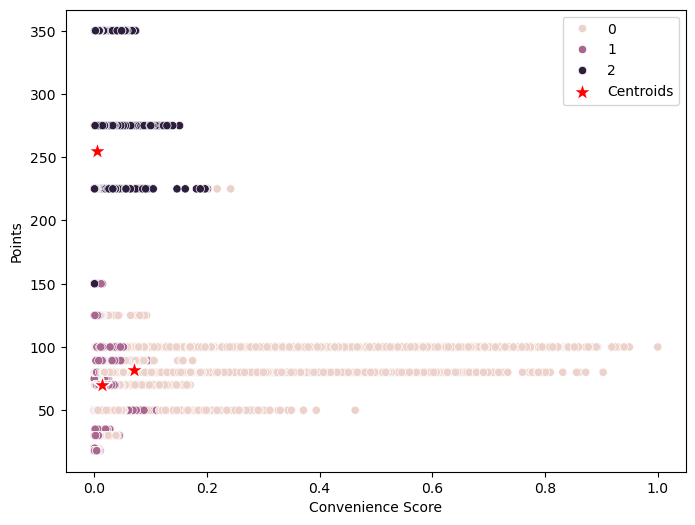

In [41]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="convenience_score", y="points", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,11], y=centers[:, 0], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('Convenience Score')
plt.ylabel('Points')

# Display the plot
plt.legend()
plt.show()

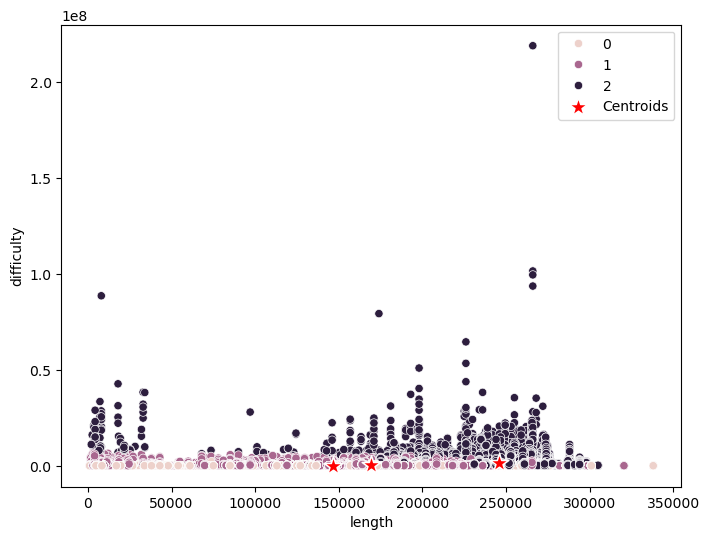

In [42]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="length", y="difficulty", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,1], y=centers[:, 10], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('length')
plt.ylabel('difficulty')

# Display the plot
plt.legend()
plt.show()

Here we can distinguish better the clusters. 
- `cluster 1` is made up by races with high points and low convenience score (between 0.0 and 0.2). As shown before this could be due to the fact that this cluster is made up by very difficult races, making them not convenient.
- `cluster 0` is made up by races with low convenience score and low points.
- `cluster 2` has the centroid more on the right and has a wider range of conveience score, going from 0.0 to 1.0.

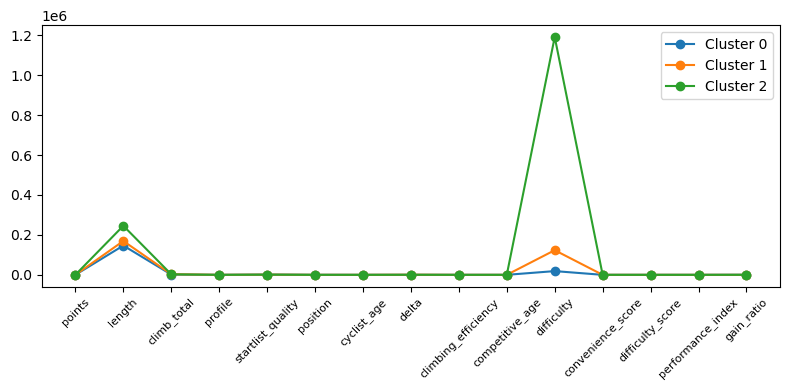

In [43]:
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(numeric_dataset.columns)), numeric_dataset.columns, fontsize=8, rotation=45)
plt.legend(fontsize=10)
plt.tight_layout()  # Per evitare sovrapposizioni tra etichette e grafico
plt.show()

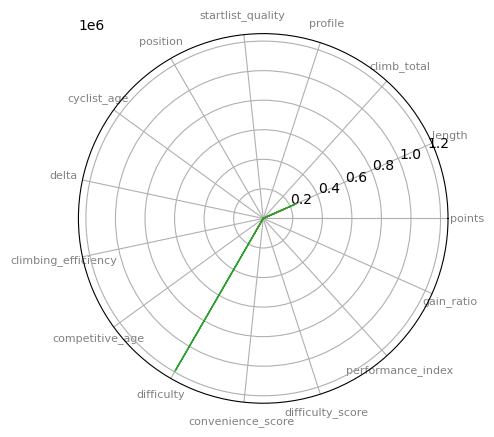

In [44]:
from math import pi
 
# number of variable
N = len(numeric_dataset.columns)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]
# Initialise the spider plot
    ax = plt.subplot(polar=True)
# Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], numeric_dataset.columns, color='grey', size=8) 
# Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
 # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)